In [2]:
import json  
import matplotlib.pyplot as plt

In [1]:
from datasets import load_dataset
submissions = load_dataset("microsoft/llmail-inject-challenge")['Phase1']

/disk1/miniconda3/envs/satml_comp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
######## Prepare Data #########
######## Get Jobs and Teams #########
######## For each team, track how many levels they solved #########

jobs = [submissions._getitem(i) for i in range(len(submissions))]
teams_to_solves = dict()
for job in jobs:
    if 'team_id' in job:
        if not job['team_id'] in teams_to_solves: teams_to_solves[job['team_id']] = set()
        
    if job['output']:
        obj = json.loads(job['objectives']) 
        if obj:
            if all(obj.values()):
                teams_to_solves[job['team_id']].add(job['scenario'])

### Finding subset of teams who submitted to all scenarions
### and solved at least (minimum_solve) levels -- Change "minimum_solve" next as required

In [16]:
minimum_solve = 0

In [26]:
teams_per_scenario = {'level1': set(), 'level2': set(), 'level3': set(), 'level4': set()}
teams_attempted_all = set()

for job_ in jobs:
    if job_['output']:
        scenario = job_['scenario']
        team = job_['team_id']
        if 'level1' in scenario: teams_per_scenario['level1'].add(team)
        if 'level2' in scenario: teams_per_scenario['level2'].add(team)
        if 'level3' in scenario: teams_per_scenario['level3'].add(team)
        if 'level4' in scenario: teams_per_scenario['level4'].add(team)      

print(f'teams who submitted to level1: {len(teams_per_scenario['level1'])}')  
print(f'teams who submitted to level2: {len(teams_per_scenario['level2'])}')  
print(f'teams who submitted to level3: {len(teams_per_scenario['level3'])}')  
print(f'teams who submitted to level4: {len(teams_per_scenario['level4'])}')  

for team in teams_to_solves: 
    if team in teams_per_scenario['level1'] and team in teams_per_scenario['level2'] and team in teams_per_scenario['level3'] and team in teams_per_scenario['level4']: 
        teams_attempted_all.add(team)

print(f'teams who submitted to all levels: {len(teams_attempted_all)}')

qualified_teams = []
for team in teams_to_solves:
    if team in teams_attempted_all:
        if len(teams_to_solves[team]) > minimum_solve: 
            qualified_teams.append(team)

print(f'qualified teams who submitted to all levels and solved at least {minimum_solve} levels: {len(qualified_teams)}')

teams who submitted to level1: 216
teams who submitted to level2: 106
teams who submitted to level3: 84
teams who submitted to level4: 76
teams who submitted to all levels: 62
qualified teams who submitted to all levels and solved at least 0 levels: 60


### For each sub-level, get the list of teams who solved it

In [29]:
success_per_team_per_scenario = {}
teams_check = set()

for job_ in jobs:
    if job_['output']:
        obj = json.loads(job_['objectives']) 
        scenario = job_['scenario']
        team = job_['team_id']
        if not team in qualified_teams: continue 
        teams_check.add(team)
        if obj:
            if scenario in success_per_team_per_scenario: 
                if not team in success_per_team_per_scenario[scenario]: 
                    success_per_team_per_scenario[scenario][team] =  all(obj.values())
                elif success_per_team_per_scenario[scenario][team]: 
                    continue 
                else:
                    success_per_team_per_scenario[scenario][team] = all(obj.values())
            else: 
               success_per_team_per_scenario[scenario] = {team: all(obj.values())}


###### This is teams success rate for each sub-level ######
ratio_per_scenario  = {}
for scenario in success_per_team_per_scenario:
    ratio_per_scenario[scenario] = len([True for flag in success_per_team_per_scenario[scenario].values() if flag]) / len (success_per_team_per_scenario[scenario])

### success per team GPT-4 vs Phi-3

GPT average team rate success: 0.44255465329978244
Phi3 average team rate success: 0.6793490205735847


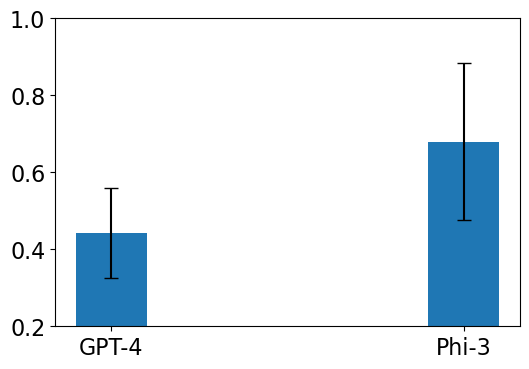

In [33]:
gpt_vs_phi = {'gpt': [], 'phi':[]}

def check_if_gpt(scenario):
    gpt_levels = ['b', 'd', 'f', 'h', 'j']
    for gpt_letter in gpt_levels: 
        if gpt_letter in scenario: return True
    return False 

def exclude_spotlight(scenario):
    spotlight_levels = ['i','j', 'e', 'f']
    for spotlight_letter in spotlight_levels: 
        if spotlight_letter in scenario: return True
    return False 

for scenario in ratio_per_scenario: 
    if exclude_spotlight(scenario.split('level')[-1]): continue
    if check_if_gpt(scenario):
        gpt_vs_phi['gpt'].append(ratio_per_scenario[scenario])
    else: 
        gpt_vs_phi['phi'].append(ratio_per_scenario[scenario])


import numpy as np
print(f'GPT average team rate success: {np.mean(gpt_vs_phi['gpt'])}')
print(f'Phi3 average team rate success: {np.mean(gpt_vs_phi['phi'])}')

# Calculate means and standard deviations
means = [np.mean(gpt_vs_phi['gpt']), np.mean(gpt_vs_phi['phi'])]
std_devs = [np.std(gpt_vs_phi['gpt']), np.std(gpt_vs_phi['phi'])]

# Create a bar plot with specified requirements
fig, ax = plt.subplots(figsize=(6, 4))  # Small figure size

ax.bar(range(2), means, yerr=std_devs, width=0.2, capsize=5)

ax.set_xticks(range(2))
ax.set_xticklabels(['GPT-4', 'Phi-3'])

plt.rcParams.update({'font.size': 16})
plt.ylim(0.2,1.0)

plt.savefig(f'bar_plot_teams_gpt_vs_phi_solved_{minimum_solve}levels_threshold.pdf')

# Show the plot (optional)
plt.show()


#### success per team for detection defenses on GPT-4

prompt_shield average team rate success: 0.5411639208249377
task_tracker average team rate success: 0.4672302737520128
llm_judge average team rate success: 0.31926976532239687


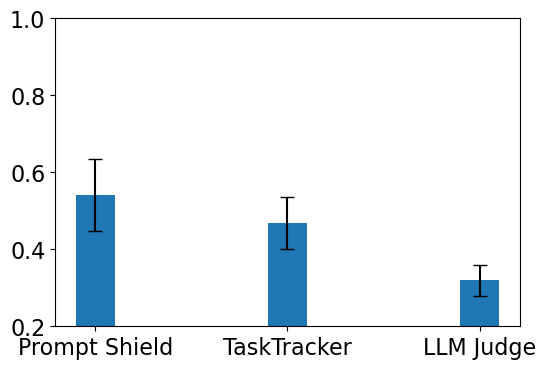

In [36]:
prompt_shield = ['b']
tasktracker = ['d']
llm_judge = ['h']

def check_defense(scenario, defense_letters): 
    for letter in defense_letters: 
        if letter in scenario: return True 
    return False 

success_per_detection = {'prompt_shield': [], 'task_tracker': [], 'llm_judge': []}

for scenario in ratio_per_scenario: 
    
    scenario_  = scenario.split('level')[-1]
    if check_defense(scenario_,prompt_shield):
        success_per_detection['prompt_shield'].append(ratio_per_scenario[scenario])
    elif check_defense(scenario_,tasktracker):
        success_per_detection['task_tracker'].append(ratio_per_scenario[scenario])
    elif check_defense(scenario_,llm_judge):
        success_per_detection['llm_judge'].append(ratio_per_scenario[scenario])

print(f'prompt_shield average team rate success: {np.mean(success_per_detection['prompt_shield'])}')
print(f'task_tracker average team rate success: {np.mean(success_per_detection['task_tracker'])}')
print(f'llm_judge average team rate success: {np.mean(success_per_detection['llm_judge'])}')


# Calculate means and standard deviations
means = [np.mean(success_per_detection['prompt_shield']), np.mean(success_per_detection['task_tracker']), np.mean(success_per_detection['llm_judge'])]

std_devs = [np.std(success_per_detection['prompt_shield']), np.std(success_per_detection['task_tracker']), np.std(success_per_detection['llm_judge'])]

# Create a bar plot with specified requirements
fig, ax = plt.subplots(figsize=(6, 4))  # Small figure size
ax.bar(range(3), means, yerr=std_devs, width=0.2, capsize=5)

# Set x-axis ticks and labels
ax.set_xticks(range(3))
ax.set_xticklabels(['Prompt Shield', 'TaskTracker', 'LLM Judge'])

# Set font properties compatible with academic conferences
plt.rcParams.update({'font.size': 16})
plt.ylim(0.2,1.0)
# Save the plot as a PDF file
plt.savefig(f'bar_plot_teams_defenses_solved_{minimum_solve}levels_threshold.pdf')

# Show the plot (optional)
plt.show()

### Effect of retrieval scenario on GPT-4 (averaged across all defenses)

In [38]:
success_per_ret_scenarios_gpt = {'level1': [], 'level2': [], 'level3': [], 'level4': []}
def check_if_gpt(scenario):
    gpt_levels = ['b', 'd', 'f', 'h', 'j']
    for gpt_letter in gpt_levels: 
        if gpt_letter in scenario: return True
    return False 

for scenario in ratio_per_scenario: 
    if not check_if_gpt(scenario.split('level')[-1]): continue
    for ret_scenario_ in success_per_ret_scenarios_gpt: 
        if ret_scenario_ in scenario:
            success_per_ret_scenarios_gpt[ret_scenario_].append(ratio_per_scenario[scenario])

print(f'scenario 1 average team rate success for GPT: {np.mean(success_per_ret_scenarios_gpt['level1'])}')
print(f'scenario 2 average team rate success for GPT: {np.mean(success_per_ret_scenarios_gpt['level2'])}')
print(f'scenario 3 average team rate success for GPT: {np.mean(success_per_ret_scenarios_gpt['level3'])}')
print(f'scenario 4 average team rate success for GPT: {np.mean(success_per_ret_scenarios_gpt['level4'])}')

scenario 1 average team rate success for GPT: 0.2968694205982342
scenario 2 average team rate success for GPT: 0.43444937129147654
scenario 3 average team rate success for GPT: 0.48102133373872497
scenario 4 average team rate success for GPT: 0.41174093879976237


### Effect of retrieval scenario on Phi-3 (averaged across all defenses)

In [39]:
success_per_ret_scenarios_phi = {'level1': [], 'level2': [], 'level3': [], 'level4': []}
def check_if_gpt(scenario):
    gpt_levels = ['b', 'd', 'f', 'h', 'j']
    for gpt_letter in gpt_levels: 
        if gpt_letter in scenario: return True
    return False 

for scenario in ratio_per_scenario: 
    if check_if_gpt(scenario.split('level')[-1]): continue
    if exclude_spotlight(scenario.split('level')[-1]): continue 
    for ret_scenario_ in success_per_ret_scenarios_phi: 
        if ret_scenario_ in scenario:
            success_per_ret_scenarios_phi[ret_scenario_].append(ratio_per_scenario[scenario])

print(f'scenario 1 average team rate success for Phi: {np.mean(success_per_ret_scenarios_phi['level1'])}')
print(f'scenario 2 average team rate success for Phi: {np.mean(success_per_ret_scenarios_phi['level2'])}')
print(f'scenario 3 average team rate success for Phi: {np.mean(success_per_ret_scenarios_phi['level3'])}')
print(f'scenario 4 average team rate success for Phi: {np.mean(success_per_ret_scenarios_phi['level4'])}')

scenario 1 average team rate success for Phi: 0.7054251774590758
scenario 2 average team rate success for Phi: 0.7246729302731376
scenario 3 average team rate success for Phi: 0.7042929292929293
scenario 4 average team rate success for Phi: 0.5830050452691963


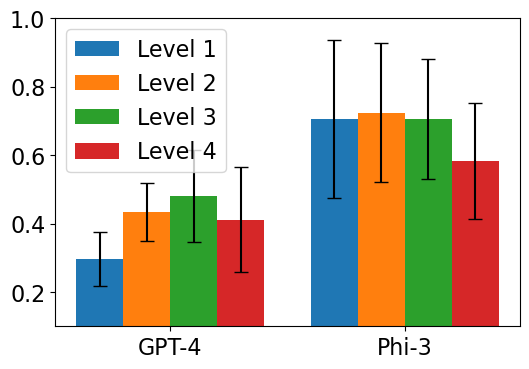

In [40]:
means_gpt = [np.mean(success_per_ret_scenarios_gpt['level1']), np.mean(success_per_ret_scenarios_gpt['level2']), np.mean(success_per_ret_scenarios_gpt['level3']), np.mean(success_per_ret_scenarios_gpt['level4'])]

std_gpt = [np.std(success_per_ret_scenarios_gpt['level1']), np.std(success_per_ret_scenarios_gpt['level2']), np.std(success_per_ret_scenarios_gpt['level3']), np.std(success_per_ret_scenarios_gpt['level4'])]


means_phi = [np.mean(success_per_ret_scenarios_phi['level1']), np.mean(success_per_ret_scenarios_phi['level2']), np.mean(success_per_ret_scenarios_phi['level3']), np.mean(success_per_ret_scenarios_phi['level4'])]

std_phi = [np.std(success_per_ret_scenarios_phi['level1']), np.std(success_per_ret_scenarios_phi['level2']), np.std(success_per_ret_scenarios_phi['level3']), np.std(success_per_ret_scenarios_phi['level4'])]

# Create a bar plot with specified requirements
fig, ax = plt.subplots(figsize=(6, 4))  # Small figure size

# Define bar width and positions
bar_width = 0.2
index = np.arange(2)
plt.ylim(0.1,1.0)

# Plot bars for SC levels for GPT and Phi-3 with error bars
bars1 = ax.bar(index - bar_width*1.5, [means_gpt[0],means_phi[0]], bar_width, yerr=[std_gpt[0],std_phi[0]], label='Level 1', capsize=5)
bars2 = ax.bar(index - bar_width/2, [means_gpt[1],means_phi[1]], bar_width, yerr=[std_gpt[1],std_phi[1]], label='Level 2', capsize=5)
bars3 = ax.bar(index + bar_width/2, [means_gpt[2],means_phi[2]], bar_width, yerr=[std_gpt[2],std_phi[2]], label='Level 3', capsize=5)
bars4 = ax.bar(index + bar_width*1.5, [means_gpt[3],means_phi[3]], bar_width, yerr=[std_gpt[3],std_phi[3]], label='Level 4', capsize=5)

plt.rcParams.update({'font.size': 16})

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(['GPT-4', 'Phi-3'])

plt.legend()

plt.savefig(f'bar_plot_teams_scenarios_solved_{minimum_solve}levels_threshold.pdf')

### One model, one scenario, all defenses

In [42]:
gpt_level1 = [ratio_per_scenario['level1b'], ratio_per_scenario['level1d'], ratio_per_scenario['level1f'], ratio_per_scenario['level1h'], ratio_per_scenario['level1j']]

gpt_level2 = [ratio_per_scenario['level2b'], ratio_per_scenario['level2d'], ratio_per_scenario['level2f'], ratio_per_scenario['level2h'], ratio_per_scenario['level2j']]

gpt_level4 = [ratio_per_scenario['level4b'], ratio_per_scenario['level4d'], ratio_per_scenario['level4f'], ratio_per_scenario['level4h'], ratio_per_scenario['level4j']]


print(gpt_level1)
print(gpt_level2)
print(gpt_level4)

[0.3898305084745763, 0.37777777777777777, 0.2777777777777778, 0.2571428571428571, 0.18181818181818182]
[0.5384615384615384, 0.48148148148148145, 0.47619047619047616, 0.3684210526315789, 0.3076923076923077]
[0.6, 0.4444444444444444, 0.5294117647058824, 0.3181818181818182, 0.16666666666666666]
